In [1]:
from src.config import *

In [2]:
import pandas as pd
import numpy as np 

In [3]:
df = pd.read_csv(TRANSFORMED_DATA_DIR / "transformed_data_6h.csv")
df

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,station_id,target
0,15,38,43,43,10,12,73,40,2,15,...,2,21,16,6,6,22,15,2022-01-01 00:00:00,HB101,8
1,38,43,43,10,12,73,40,2,15,50,...,21,16,6,6,22,15,8,2022-01-01 06:00:00,HB101,4
2,43,43,10,12,73,40,2,15,50,40,...,16,6,6,22,15,8,4,2022-01-01 12:00:00,HB101,4
3,43,10,12,73,40,2,15,50,40,2,...,6,6,22,15,8,4,4,2022-01-01 18:00:00,HB101,3
4,10,12,73,40,2,15,50,40,2,34,...,6,22,15,8,4,4,3,2022-01-02 00:00:00,HB101,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,5,1,5,13,9,3,13,19,9,3,...,0,10,10,5,3,4,12,2023-12-30 18:00:00,HB305,4
8756,1,5,13,9,3,13,19,9,3,16,...,10,10,5,3,4,12,4,2023-12-31 00:00:00,HB305,2
8757,5,13,9,3,13,19,9,3,16,21,...,10,5,3,4,12,4,2,2023-12-31 06:00:00,HB305,6
8758,13,9,3,13,19,9,3,16,21,20,...,5,3,4,12,4,2,6,2023-12-31 12:00:00,HB305,6


In [4]:
# Ensure the 'pickup_hour' column is in datetime format
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'])

# Split the data into training (2022) and testing (2023)
train_data = df[df['pickup_hour'].dt.year == 2022]
test_data = df[df['pickup_hour'].dt.year == 2023]

# Separate features (X) and target (Y)
X_train = train_data.drop(columns=['target','pickup_hour','station_id'])
y_train = train_data['target']

X_test = test_data.drop(columns=['target','pickup_hour','station_id'])
y_test = test_data['target']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4380, 672)
(4380,)
(4380, 672)
(4380,)


In [5]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# 1. Define and train LightGBM model
model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=100,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

model.fit(X_train, y_train)

# 3. Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"LightGBM MAE: {mae:.2f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48824
[LightGBM] [Info] Number of data points in the train set: 4380, number of used features: 672
[LightGBM] [Info] Start training from score 12.978082
LightGBM MAE: 4.75


In [6]:
y_pred

array([ 6.06522006,  3.10858818, 12.60432917, ...,  4.40993799,
       10.42945385,  2.06287219])

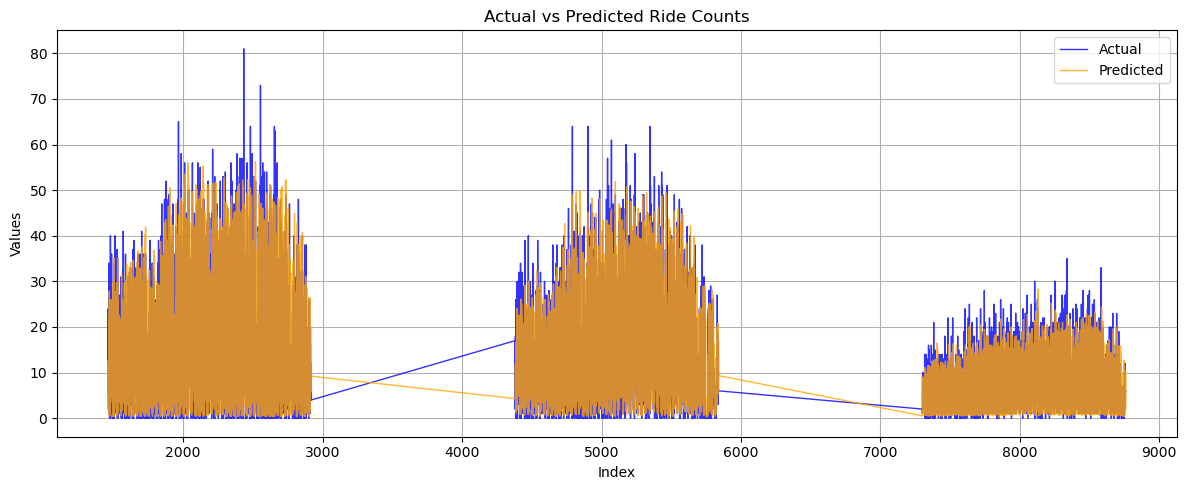

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Convert y_pred to a pandas Series with the same index as y_test
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Plot with reduced linewidth and transparency
plt.plot(y_test.index, y_test, label='Actual', color='blue', linewidth=1, alpha=0.8)
plt.plot(y_pred_series.index, y_pred_series, label='Predicted', color='orange', linewidth=1, alpha=0.8)

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Ride Counts')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Get Importance for next Model

In [8]:
import pandas as pd

importances = model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Filter only lag features (e.g., rides_t-*)
important_lags = importance_df[importance_df['Feature'].str.startswith('rides_t-')]
important_lag_list = important_lags[important_lags['Importance'] > 0]['Feature'].tolist()

print(important_lag_list[:10])  # Top 20 important lag features


['rides_t-1', 'rides_t-4', 'rides_t-28', 'rides_t-24', 'rides_t-3', 'rides_t-84', 'rides_t-56', 'rides_t-5', 'rides_t-52', 'rides_t-168']


In [9]:
import os
import joblib

# Create the directory if it doesn't exist
os.makedirs(MODELS_DIR, exist_ok=True)

# Save the model
joblib.dump(model, MODELS_DIR / "lgb_model.pkl")

['C:\\Users\\chanc\\Desktop\\City_Bike\\models\\lgb_model.pkl']

In [10]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import dagshub
dagshub.init(repo_owner='C-bundele', repo_name='City_Bike', mlflow=True)

from src.experiment_utils import set_mlflow_tracking, log_model_to_mlflow

mlflow = set_mlflow_tracking()

import mlflow

print("Current MLflow Tracking URI:", mlflow.get_tracking_uri())

mlflow.set_experiment("Lightgbm Model")

# Start an MLflow run
with mlflow.start_run():
        mlflow.log_metric("mean_absolute_error",mae)

Accessing as C-bundele

Initialized MLflow to track repo "C-bundele/City_Bike"

Repository C-bundele/City_Bike initialized!

Current MLflow Tracking URI: https://dagshub.com/C-bundele/City_Bike.mlflow


2025/05/10 11:29:35 INFO mlflow.tracking.fluent: Experiment with name 'Lightgbm Model' does not exist. Creating a new experiment.


🏃 View run rumbling-sloth-191 at: https://dagshub.com/C-bundele/City_Bike.mlflow/#/experiments/1/runs/1eb1ed38cfd247ad96c294084a251cd9
🧪 View experiment at: https://dagshub.com/C-bundele/City_Bike.mlflow/#/experiments/1
